<a href="https://colab.research.google.com/github/butoialexandra/Determining-country-specific-engagement-in-climate-change-policies/blob/main/topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
cd drive/MyDrive/

/content/drive/MyDrive


In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 4.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
import re
import numpy as np
import pandas as pd
import glob
from pprint import pprint

In [4]:
!pip install pyLDAvis==3.2.1

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=8127f4324b4fc24b4605bb3b835cf715e8cb01e24686b74d0da437c99b191c17
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis
  Attempting uninstall: pyLDAvis
    Found existing installation: pyLDAvis 3.3.1
    Uninstalling pyLDAvis-3.3.1:
      Successfully uninstalled pyLDAvis-3.3.1


In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [21]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['image', 'bpc', 'width', 'height', 'devicergb'])

In [12]:
docs = [f for f in glob.glob("txts/*.txt")]

In [7]:
def country_name(doc):
    pos1 = doc.find('_')+1
    pos2 = doc.find('_', pos1)
    return doc[pos1:pos2]

In [13]:
texts = []
countries = []
for doc in docs:
    with open(doc, 'r') as f:
        text = f.read()
    texts.append(text)
    countries.append(country_name(doc))

In [14]:
data = {
    'Country': countries,
    'NDC': texts
}
df = pd.DataFrame.from_dict(data)

In [15]:
df

,Country,NDC
0,Sao-Tome-and-Principe,SAO TOME AND PRINCIPEINTENDED NATIONALLY DETER...
1,Malaysia,1 INTENDED NATIONALLY DETERMINED CONTRIBUTION ...
2,Bangladesh,"1 image ICCBased(RGB,sRGB IEC619662.1), width ..."
3,Micronesia,"image ICCBased(RGB,sRGB IEC619662.1), width 13..."
4,Grenada,"image DeviceRGB, width 1721, height 265, bpc 8..."
...,...,...
164,Marshall-Islands,The Republic of the Marshall Islands Nationall...
165,Barbados,1 Barbados Intended Nationally Determined Cont...
166,Thailand,....................... .................... ....
167,Armenia,"image DeviceRGB, width 1275, height 1737, bpc ..."


In [16]:
df['NDC_processed'] = df['NDC'].apply(lambda x: re.sub('[(),\.!?0-9]', '', x))
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.lower())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.strip())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: re.sub(' +', ' ', x))

In [17]:
df

,Country,NDC,NDC_processed
0,Sao-Tome-and-Principe,SAO TOME AND PRINCIPEINTENDED NATIONALLY DETER...,sao tome and principeintended nationally deter...
1,Malaysia,1 INTENDED NATIONALLY DETERMINED CONTRIBUTION ...,intended nationally determined contribution of...
2,Bangladesh,"1 image ICCBased(RGB,sRGB IEC619662.1), width ...",image iccbasedrgbsrgb iec width height bpc int...
3,Micronesia,"image ICCBased(RGB,sRGB IEC619662.1), width 13...",image iccbasedrgbsrgb iec width height bpc fed...
4,Grenada,"image DeviceRGB, width 1721, height 265, bpc 8...",image devicergb width height bpc image devicer...
...,...,...,...
164,Marshall-Islands,The Republic of the Marshall Islands Nationall...,the republic of the marshall islands nationall...
165,Barbados,1 Barbados Intended Nationally Determined Cont...,barbados intended nationally determined contri...
166,Thailand,....................... .................... ....,image iccbasedrgbsrgb iec width height bpc ima...
167,Armenia,"image DeviceRGB, width 1275, height 1737, bpc ...",image devicergb width height bpc protocol deci...


In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [23]:
ndcs = df.NDC_processed.values.tolist()
words = list(sent_to_words(ndcs))

In [26]:
pprint(words[:1])

Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  'devicergb',
  'width',
  'height',
  'bpc',
  'image',
  

In [27]:
bigram = gensim.models.Phrases(words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [28]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [29]:
print(trigram_mod[bigram_mod[words[0]]])

['sao_tome', 'and', 'nationally_determined', 'supported', 'by', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'width', 'height', 'bpc', 'image', 'devicergb', 'w

In [30]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [31]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [32]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [33]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [34]:
data_words_nostops = remove_stopwords(words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['support', 'principe', 'ntende', 'nationally_determined', 'contribution', 'ntende', 'contribution', 'ofintende', 'nationally', 'national', 'background', 'development', 'principe', 'stp', 'state', 'consist', 'island', 'several', 'islet', 'locate', 'area', 'kminhabitant', 'need', 'furthermoredebt', 'rate', 'high', 'gdp', 'country', 'absolute', 'sink', 'sequestration', 'co', 'change', 'cc', 'climate', 'change', 'adaptation', 'risk', 'national', 'authority', 'stp', 'take', 'step', 'contribute', 'reduction', 'national', 'adaptation', 'mitigation', 'requirethrough', 'external', 'assistance', 'state', 'environmental', 'environment', 'general', 'dgpresidential', 'decree', 'involve', 'implementation', 'climate', 'change', 'collaboration', 'national', 'law', 'basic', 'law', 'environment', 'principe', 'decree', 'publish', 'create', 'committee', 'climate', 'evaluation', 'climate', 'change', 'contribution', 'term', 'adaptation', 'process', 'develop', 'principe', 'benchmark', 'national', 'priority

In [35]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 3), (4, 3), (5, 2), (6, 6), (7, 1), (8, 5), (9, 1), (10, 1), (11, 3), (12, 5), (13, 13), (14, 2), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 3), (24, 1), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 5), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 3), (38, 4), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 3), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 11), (61, 1), (62, 1), (63, 14), (64, 2), (65, 2), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 4), (72, 1), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 2), (79, 1), (80, 2), (81, 2), (82, 3), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 6), (89, 10), (90, 2), (91, 1), (92, 16), (93, 1), (94, 3), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 3), (101, 3), (102, 1), (103, 3), (104, 6), (105, 4), (106, 1), (107, 1), (108, 1), (109, 1), (11

In [36]:
id2word[0]

'ability'

In [37]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 2),
  ('able', 1),
  ('abroad', 1),
  ('absence', 3),
  ('absolute', 3),
  ('absorption', 2),
  ('access', 6),
  ('accident', 1),
  ('accord', 5),
  ('account', 1),
  ('achieve', 1),
  ('action', 3),
  ('activity', 5),
  ('adaptation', 13),
  ('addition', 2),
  ('additional', 2),
  ('adequate', 2),
  ('adverse', 1),
  ('afadaptation', 1),
  ('affected', 1),
  ('agree', 1),
  ('agriculture', 1),
  ('agro', 2),
  ('aid', 3),
  ('aimedimage', 1),
  ('already', 3),
  ('also', 1),
  ('analysis', 1),
  ('apart', 1),
  ('apply', 1),
  ('approximately', 1),
  ('area', 5),
  ('assistance', 1),
  ('attract', 1),
  ('authority', 1),
  ('availability', 3),
  ('background', 1),
  ('barrier', 3),
  ('base', 4),
  ('basic', 2),
  ('basis', 1),
  ('benchmark', 1),
  ('board', 1),
  ('broad', 1),
  ('budget', 2),
  ('bythe', 1),
  ('calculate', 1),
  ('calculation', 2),
  ('call', 1),
  ('capacity_builde', 3),
  ('capacity_building', 1),
  ('carbon', 1),
  ('carbon_sink', 1),
  ('cause', 

In [38]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [39]:
lda_model.print_topics()

[(0,
  '0.000*"climate" + 0.000*"change" + 0.000*"adaptation" + 0.000*"national" + 0.000*"emission" + 0.000*"energy" + 0.000*"sector" + 0.000*"increase" + 0.000*"use" + 0.000*"mitigation"'),
 (1,
  '0.015*"sector" + 0.012*"plan" + 0.010*"como" + 0.008*"son" + 0.007*"plane" + 0.006*"contribucione" + 0.006*"pase" + 0.006*"este" + 0.006*"actore" + 0.006*"capacidade"'),
 (2,
  '0.029*"climate" + 0.019*"adaptation" + 0.017*"change" + 0.012*"sector" + 0.009*"national" + 0.009*"development" + 0.008*"action" + 0.008*"include" + 0.008*"increase" + 0.008*"mitigation"'),
 (3,
  '0.017*"climate" + 0.017*"png" + 0.016*"development" + 0.012*"target" + 0.011*"sector" + 0.010*"percent" + 0.009*"area" + 0.009*"chile" + 0.009*"change" + 0.008*"adaptation"'),
 (4,
  '0.455*"none" + 0.020*"togo" + 0.005*"promotion" + 0.004*"indc" + 0.004*"landuse" + 0.003*"national" + 0.003*"iintended_nationally" + 0.003*"fight" + 0.003*"scape" + 0.002*"regional"'),
 (5,
  '0.034*"comore" + 0.022*"lunion_de" + 0.007*"fsm"

In [40]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"climate" + 0.000*"change" + 0.000*"adaptation" + 0.000*"national" + '
  '0.000*"emission" + 0.000*"energy" + 0.000*"sector" + 0.000*"increase" + '
  '0.000*"use" + 0.000*"mitigation"'),
 (1,
  '0.015*"sector" + 0.012*"plan" + 0.010*"como" + 0.008*"son" + 0.007*"plane" '
  '+ 0.006*"contribucione" + 0.006*"pase" + 0.006*"este" + 0.006*"actore" + '
  '0.006*"capacidade"'),
 (2,
  '0.029*"climate" + 0.019*"adaptation" + 0.017*"change" + 0.012*"sector" + '
  '0.009*"national" + 0.009*"development" + 0.008*"action" + 0.008*"include" + '
  '0.008*"increase" + 0.008*"mitigation"'),
 (3,
  '0.017*"climate" + 0.017*"png" + 0.016*"development" + 0.012*"target" + '
  '0.011*"sector" + 0.010*"percent" + 0.009*"area" + 0.009*"chile" + '
  '0.009*"change" + 0.008*"adaptation"'),
 (4,
  '0.455*"none" + 0.020*"togo" + 0.005*"promotion" + 0.004*"indc" + '
  '0.004*"landuse" + 0.003*"national" + 0.003*"iintended_nationally" + '
  '0.003*"fight" + 0.003*"scape" + 0.002*"regional"'),
 (5,
 

In [41]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.196961125919643

Coherence Score:  0.44040617054345954


In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.306214 -0.005928       1        1  45.741700
8      0.313820 -0.012380       2        1  16.429336
2      0.315377 -0.005424       3        1  14.205032
14     0.295262 -0.019110       4        1  13.418608
19     0.260937 -0.014105       5        1   3.335921
7     -0.041553  0.370504       6        1   2.884682
3      0.170044 -0.029056       7        1   1.548716
13    -0.146621 -0.099061       8        1   0.609566
6      0.008687 -0.023326       9        1   0.570985
1     -0.164221 -0.097229      10        1   0.456078
4     -0.125629 -0.006067      11        1   0.367609
9     -0.016966 -0.020714      12        1   0.305829
5     -0.156931 -0.010019      13        1   0.090700
18    -0.151273 -0.005359      14        1   0.025433
15    -0.145005 -0.004455      15        1   0.006748
11    -0.144245 -0.003689      16        1   0.000628
10    -0.144305 -0.003658      17        1   0.000620
16    -0.144364 -0.003635      18        1   0.000616
0     -0.144539 -0.003656      19        1   0.000613
17    -0.144691 -0.003632      20        1   0.000581, topic_info=            Term         Freq        Total Category  logprob  loglift
356       sector  4417.000000  4417.000000  Default  30.0000  30.0000
63       climate  7615.000000  7615.000000  Default  29.0000  29.0000
303      project  1721.000000  1721.000000  Default  28.0000  28.0000
1959        none   655.000000   655.000000  Default  27.0000  27.0000
192         indc  1078.000000  1078.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
342     resource     0.000148  1697.208470  Topic20  -9.6351  -4.1967
285       policy     0.000148  2114.459456  Topic20  -9.6355  -4.4169
260         need     0.000148  1431.024715  Topic20  -9.6361  -4.0271
390   technology     0.000148  1126.135072  Topic20  -9.6363  -3.7877
192         indc     0.000148  1078.650763  Topic20  -9.6365  -3.7448

[1286 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14513      8  0.978680  absorbida
5430       8  0.687663    accione
5430      10  0.305628    accione
9          1  0.264144    account
9          2  0.430389    account
...      ...       ...        ...
2273       2  0.015201       zone
2273       3  0.020269       zone
2273       4  0.060806       zone
2273       5  0.035470       zone
2273       6  0.202685       zone

[1999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 9, 3, 15, 20, 8, 4, 14, 7, 2, 5, 10, 6, 19, 16, 12, 11, 17, 1, 18])

In [44]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-07-31 00:07:53--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  18.0MB/s    in 0.9s    

2021-07-31 00:07:54 (18.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip mallet-2.0.8.zip

In [46]:
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [47]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [('indc', 0.05989884393063584),
   ('adaptation', 0.030130057803468207),
   ('national', 0.023554913294797687),
   ('change', 0.019942196531791908),
   ('objective', 0.019219653179190752),
   ('country', 0.018063583815028903),
   ('action', 0.013222543352601156),
   ('investment', 0.011705202312138728),
   ('priority', 0.011488439306358381),
   ('year', 0.010982658959537572)]),
 (10,
  [('strategy', 0.019149373330593796),
   ('energy', 0.018985001027326896),
   ('policy', 0.017300184918841176),
   ('include', 0.016642695705773577),
   ('emission', 0.014711321142387507),
   ('reduce', 0.014588041914937334),
   ('electricity', 0.013026505033901788),
   ('efficiency', 0.012985411958085063),
   ('renewable', 0.012697760427367989),
   ('cost', 0.012410108896650915)]),
 (3,
  [('emission', 0.03347814975721952),
   ('include', 0.03230258113979044),
   ('paris_agreement', 0.022386915410171224),
   ('contribution', 0.019984666496294403),
   ('target', 0.01880909787886532),
   ('ndc', 0.

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [49]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

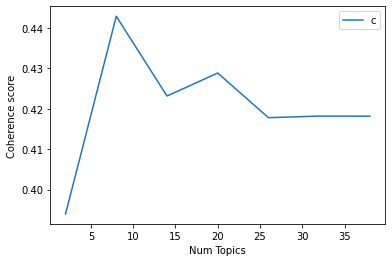

In [50]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.394
Num Topics = 8  has Coherence Value of 0.4429
Num Topics = 14  has Coherence Value of 0.4232
Num Topics = 20  has Coherence Value of 0.4288
Num Topics = 26  has Coherence Value of 0.4178
Num Topics = 32  has Coherence Value of 0.4182
Num Topics = 38  has Coherence Value of 0.4182


In [52]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.062*"energy" + 0.042*"sector" + 0.039*"emission" + 0.026*"mitigation" + '
  '0.019*"measure" + 0.017*"policy" + 0.015*"change" + 0.015*"growth" + '
  '0.014*"efficiency" + 0.013*"total"'),
 (1,
  '0.043*"energy" + 0.022*"water" + 0.019*"technology" + 0.014*"action" + '
  '0.014*"finance" + 0.013*"waste" + 0.012*"enhance" + 0.010*"building" + '
  '0.010*"improve" + 0.009*"infrastructure"'),
 (2,
  '0.052*"climate" + 0.046*"change" + 0.043*"national" + 0.029*"development" + '
  '0.018*"adaptation" + 0.017*"plan" + 0.015*"country" + 0.015*"action" + '
  '0.013*"resource" + 0.012*"strategy"'),
 (3,
  '0.016*"water" + 0.015*"production" + 0.015*"community" + 0.014*"land" + '
  '0.014*"project" + 0.014*"resource" + 0.013*"area" + 0.013*"management" + '
  '0.010*"potential" + 0.010*"local"'),
 (4,
  '0.020*"pour" + 0.020*"dan" + 0.018*"mission" + 0.014*"climatique" + '
  '0.013*"dveloppement" + 0.010*"plan" + 0.010*"action" + 0.010*"pay" + '
  '0.008*"production" + 0.008*"contributi